Практика. VAE

Перейдём к вариационным автоэнкодерам (англ. variational autoencoders, VAE).

Основное отличие вариационных автоэнкодеров от обычных автоэнкодеров в том, что в них используется специальное промежуточное признаковое представление и вероятностное распределение.

Использовать будем не свёрточные, а полносвязные Encoder и Decoder для быстроты обучения.

Наш dataset в этом случае — это векторизованный dataset MNIST.



In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

print(tf.__version__)

2.16.2


In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28*28).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28*28).astype(np.float32) / 255.

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)

(60000, 784) float32
(10000, 784) float32


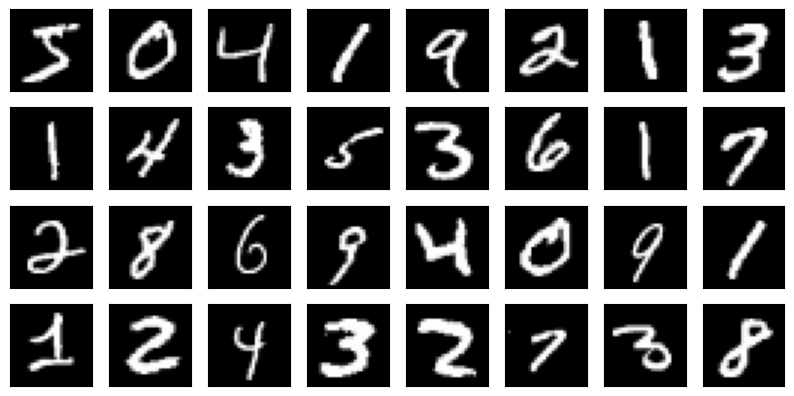

In [3]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(samples[j, ...].reshape(28, 28), cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_digits(train_x[:32, ...])

In [4]:
class Encoder(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.fc1 = L.Dense(512, activation='relu')
        self.fc2 = L.Dense(2, activation=None)
        self.fc3 = L.Dense(2, activation=None)
        
    def call(self, inp):
        h = self.fc1(inp)
        z_mean = self.fc2(h)
        z_log_sigma = self.fc3(h)
        batch_size = inp.shape[0]
        rnd = tf.random.normal(tf.shape(z_mean))
        z = z_mean + tf.exp(z_log_sigma) * rnd
        return z_mean, z_log_sigma, z

class Decoder(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.fc1 = L.Dense(512, activation='relu')
        self.fc2 = L.Dense(784, activation='sigmoid')
        
    def call(self, inp):
        h = self.fc1(inp)
        out = self.fc2(h)
        return out

encoder = Encoder()
decoder = Decoder()

In [5]:
def vae(inp):
    _, _, z = encoder.predict(inp)
    out = decoder.predict(z)
    return out

def vae_loss(inp, target):
        z_mean, z_log_sigma, z = encoder(inp)
        pred = decoder(z)
        
        mse_loss = tf.reduce_sum(tf.square(pred - target), axis=1)
        tmp = 1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma)
        KL_loss = -0.5 * tf.reduce_sum(tmp, axis=-1)
        return tf.reduce_mean(mse_loss + KL_loss)

In [6]:
NUM_EPOCHS = 2
BATCH_SIZE = 128
LEARNING_RATE = 0.001

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)

2025-03-11 10:41:04.198008: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-03-11 10:41:04.198042: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-11 10:41:04.198049: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-11 10:41:04.198243: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-11 10:41:04.198258: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
for e in range(NUM_EPOCHS):
    for batch in train_ds:    
        with tf.GradientTape() as tape:
            loss_value = vae_loss(batch, batch)
        train_vars = encoder.variables + decoder.variables
        grads = tape.gradient(loss_value, train_vars)
        optimizer.apply_gradients(zip(grads, train_vars))

    print("[Epoch %2d] Train Loss: %.4f" % (e, loss_value.numpy()))

2025-03-11 10:41:17.156493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[Epoch  0] Train Loss: 42.8403
[Epoch  1] Train Loss: 40.7778


2025-03-11 10:41:22.427608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


2025-03-11 10:41:24.354535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


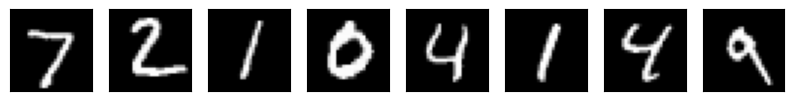

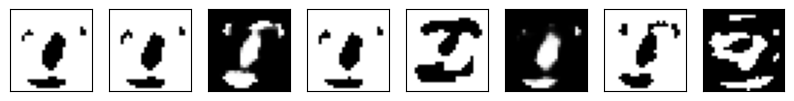

In [8]:
text_x_pred = vae(test_x[0:8])

plot_digits(test_x[0:8])
plot_digits(text_x_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

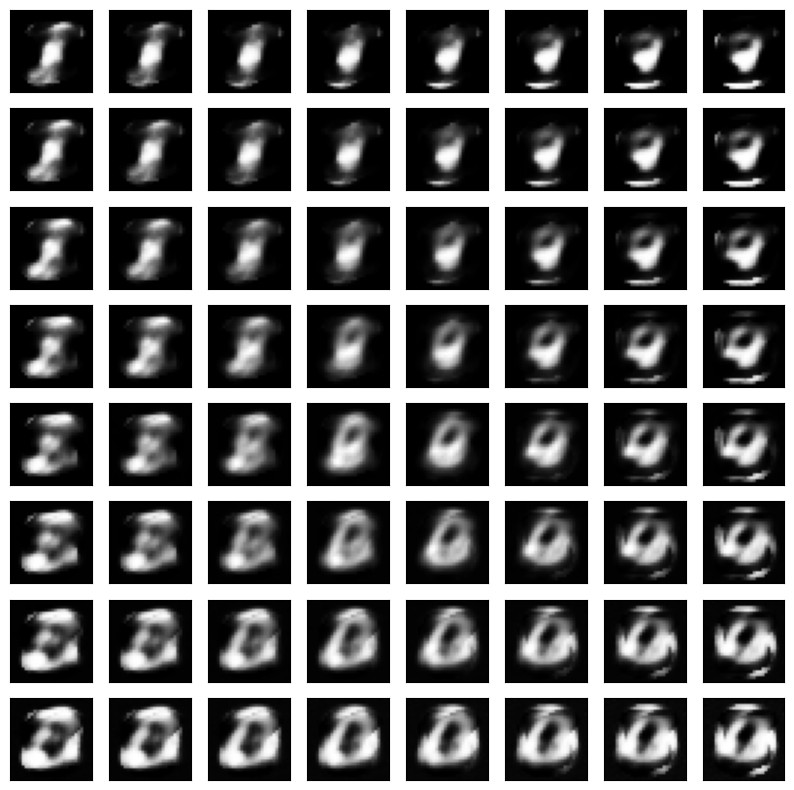

In [9]:
generated_list = []

for xi in np.linspace(-1, 1, 8):
    for xj in np.linspace(-1, 1, 8):
        generated = decoder.predict(np.array([[xi, xj]]))
        generated_list.append(generated)

plot_digits(np.concatenate(generated_list))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


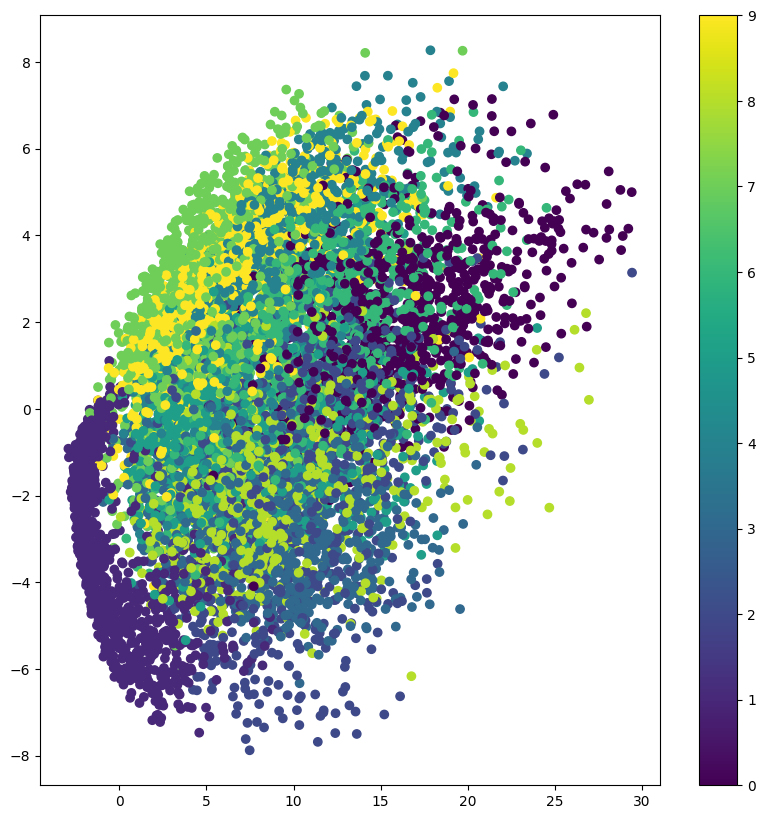

In [10]:
test_x_enc = encoder.predict(test_x)[0]
plt.figure(figsize=(10, 10))
plt.scatter(test_x_enc[:, 0], test_x_enc[:, 1], c=test_y)
plt.colorbar()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


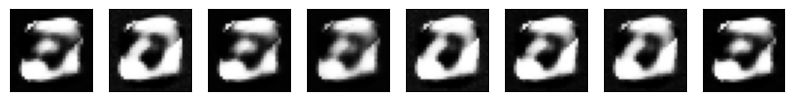

In [11]:
plot_digits(decoder.predict(np.random.rand(8, 2) + np.array([[1, -2]])))

https://apps.skillfactory.ru/learning/course/course-v1:SkillFactory+MLDL+ALWAYS/block-v1:SkillFactory+MLDL+ALWAYS+type@sequential+block@7f49b4f4f1144804bf4a049e97b3d53e/block-v1:SkillFactory+MLDL+ALWAYS+type@vertical+block@3fcac4435f4d450fa44cb01e25de74de

Видео № 2

В блоке Create VAE parts: Encoder and Decoder рассмотрим, что представляет собой вариационный автоэнкодер.

Не будем строить модель, ответственную за автоэнкодер, достаточно будет создать функцию в блоке VAE inference and loss functions, которая выполнит forward propagation. Будем использовать метод обучения через градиентную ленту.




Протестируем модель в обычном режиме, как тестировали автоэнкодеры. Так мы увидим, хорошо ли обучился сам автоэнкодер. 

Рассмотрим визуализацию.

Дополнительно добавим ячейку с кодом

plot_digits(decoder.predict(np.random.rand(8, 2) + np.array([[1, -1]])))